In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor


In [49]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

In [611]:
temp_fixtures=pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2020-21/fixtures.csv")
temp.columns
#team_h_dif is the difficultly of the home team player

Index(['name', 'id', 'strength', 'strength_overall_home',
       'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
       'strength_defence_home', 'strength_defence_away'],
      dtype='object')

In [612]:
temp_teams=pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2020-21/teams.csv")
temp=temp_teams[['name', 'id', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away']]
temp.columns
#team_h_dif is the difficultly of the home team player

Index(['name', 'id', 'strength', 'strength_overall_home',
       'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
       'strength_defence_home', 'strength_defence_away'],
      dtype='object')

In [614]:
temp_away=temp[['name', 'id', 'strength', 'strength_overall_away', 'strength_attack_away', 'strength_defence_away']]
temp_home=temp[['name', 'id', 'strength', 'strength_overall_home', 'strength_attack_home', 'strength_defence_home']]


In [617]:
# Merge for team_a (away team)
temp_fixtures = temp_fixtures.merge(
    temp_away,
    how='left',
    left_on='team_a',
    right_on='id',
    suffixes=('', '_team_a')
)

# Merge for team_h (home team)
temp_fixtures = temp_fixtures.merge(
    temp_home,
    how='left',
    left_on='team_h',
    right_on='id',
    suffixes=('', '_team_h')
)

temp_fixtures.columns

Index(['code', 'event', 'finished', 'finished_provisional', 'id',
       'kickoff_time', 'minutes', 'provisional_start_time', 'started',
       'team_a', 'team_a_score', 'team_h', 'team_h_score', 'stats',
       'team_h_difficulty', 'team_a_difficulty', 'pulse_id', 'name',
       'id_team_a', 'strength', 'strength_overall_away',
       'strength_attack_away', 'strength_defence_away', 'name_team_h',
       'id_team_h', 'strength_team_h', 'strength_overall_home',
       'strength_attack_home', 'strength_defence_home'],
      dtype='object')

In [619]:
temp_fixtures.head(5)

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,name,id_team_a,strength,strength_overall_away,strength_attack_away,strength_defence_away,name_team_h,id_team_h,strength_team_h,strength_overall_home,strength_attack_home,strength_defence_home
0,2128288,1,True,True,2,2020-09-12T11:30:00Z,90,False,True,1,3,8,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,2,58898,Arsenal,1,4,1250,1150,1210,Fulham,8,3,1090,1150,1040
1,2128287,1,True,True,1,2020-09-12T14:00:00Z,90,False,True,16,0,6,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,3,58897,Southampton,16,3,1100,1110,1160,Crystal Palace,6,3,1090,1030,1010
2,2128289,1,True,True,3,2020-09-12T16:30:00Z,90,False,True,10,3,11,4,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,3,58899,Leeds,10,3,1170,1150,1170,Liverpool,11,4,1250,1190,1300
3,2128293,1,True,True,6,2020-09-12T19:00:00Z,90,False,True,14,2,19,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,4,58903,Newcastle,14,2,1070,1060,1110,West Ham,19,4,1230,1140,1260
4,2128292,1,True,True,5,2020-09-13T13:00:00Z,90,False,True,9,3,18,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",4,2,58902,Leicester,9,4,1260,1150,1230,West Brom,18,2,1050,1040,1050


In [4]:
def fetch_data(url, players_url, fix_url, teams_url):

    # Read CSVs
    df = pd.read_csv(url, encoding="latin1")
    df2 = pd.read_csv(players_url)
    df_fix_raw=pd.read_csv(fix_url)
    df_teams_raw=pd.read_csv(teams_url)

    # Dropping unnecessary columns and creating first_name and last_name for join
    df[['first_name', 'second_name']] = df['name'].str.split(' ', n=1, expand=True)
    df2=df2[['first_name', 'second_name', 'team', 'web_name']]
    df_fix=df_fix_raw[['id', 'team_h_difficulty', 'team_a_difficulty']]
    df_teams=df_teams_raw[['name', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away']]


    
    if 'expected_assists' in df.columns:
        df.drop('expected_assists', axis=1, inplace=True)
        df.drop('expected_goal_involvements', axis=1, inplace=True)
        df.drop('expected_goals', axis=1, inplace=True)
        df.drop('expected_goals_conceded', axis=1, inplace=True)
        df.drop('starts', axis=1, inplace=True)

    # Creating 'form' column which is mean of total points from the last 5 GWs
    df = df.sort_values(by=['name', 'GW'])
    df['form'] = (
    df.groupby('name')['total_points']
    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Ensure the index matches the original DataFrame
    )
    df['form'] = df.groupby('name')['form'].transform(lambda x: x.fillna(0))

    # Taking cummulative stats from the previous GWs
    columns_to_cumsum = ['goals_scored', 'assists', 'bonus', 'yellow_cards', 'clean_sheets', 'goals_conceded']

    # Apply cumulative sum for each column grouping by 'name', excluding the current row
    for col in columns_to_cumsum:
        df[col] = df.groupby('name')[col].cumsum().shift(1, fill_value=0)

    df.update(
    df.groupby('name')[columns_to_cumsum].transform(lambda x: x.mask(x.index == x.index.min(), 0))
    )

    df['cumulative_minutes'] = (
    df.groupby('name')['minutes']
    .cumsum()                # Compute cumulative sum
    .shift(1, fill_value=0)  # Shift down by 1 row, keeping first as 0
    )
    df['cumulative_minutes'] = df.groupby('name')['cumulative_minutes'].transform(
    lambda x: x.mask(x.index == x.index.min(), 0)
    )

    df = df.groupby('name').filter(lambda x: x['cumulative_minutes'].iloc[-1] >= 600)

    #Merging fixtures dataframe to get 'fixture difficulty'
    df=pd.merge(df, df_fix, left_on='fixture', right_on='id', how='left')
    
    df['fixture_difficulty']=np.where(df['was_home'], df['team_h_difficulty'], df['team_a_difficulty'])

    # Merging teams dataframe to obtain team strength stats
    df=pd.merge(df, df_teams, left_on='team', right_on='name', how='left')
    df['strength_overall']=np.where(df['was_home'], df['strength_overall_home'], df['strength_overall_away'])
    df['strength_attack']=np.where(df['was_home'], df['strength_attack_home'], df['strength_attack_away'])
    df['strength_defence']=np.where(df['was_home'], df['strength_defence_home'], df['strength_defence_away'])

    
    df=df.drop(['team_h_difficulty', 'team_a_difficulty', 'team_a_score', 'team_h_score', 'opponent_team', 'xP', 'kickoff_time', 'element', 'fixture'], axis=1)
    
    # Merging df2 to get team name
    merged_df=pd.merge(df, df2, on=['first_name', 'second_name'], how='inner')
    merged_df=merged_df.drop(['team_x', 'team_y', 'first_name', 'second_name', 'bps', 'round', 'name_y', 'id', 'minutes', 'own_goals', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'transfers_balance', 'GW', 'saves', 'penalties_missed', 'penalties_saved'],axis=1)
    print(merged_df.columns)

    # Seperating all positions to different dataframes
    gks=merged_df.loc[(merged_df['position']=="GK")]
    defs=merged_df.loc[(merged_df['position']=="DEF") ]
    mids=merged_df.loc[(merged_df['position']=="MID")]
    fwds=merged_df.loc[(merged_df['position']=="FWD") ]

    fwds=fwds.drop(['goals_conceded', 'clean_sheets', 'strength_defence'], axis=1)

    return gks, defs, mids, fwds

In [6]:
def fetch_data_new(url, players_url, fix_url, teams_url):

    # Read CSVs
    df = pd.read_csv(url, encoding="latin1")
    df2 = pd.read_csv(players_url)
    df_fix_raw=pd.read_csv(fix_url)
    df_teams_raw=pd.read_csv(teams_url)

    # Dropping unnecessary columns and creating first_name and last_name for join
    df[['first_name', 'second_name']] = df['name'].str.split(' ', n=1, expand=True)
    df2=df2[['first_name', 'second_name', 'team', 'web_name']]
    df_fix=df_fix_raw[['id', 'team_a', 'team_h', 'team_h_difficulty', 'team_a_difficulty']]
    df_teams=df_teams_raw[['name', 'id', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away']]
    

    teams_away=df_teams[['name', 'id', 'strength', 'strength_overall_away', 'strength_attack_away', 'strength_defence_away']]
    teams_home=df_teams[['name', 'id', 'strength', 'strength_overall_home', 'strength_attack_home', 'strength_defence_home']]

    # Merge for team_a (away team)
    df_fix = df_fix.merge(
    teams_away,
    how='left',
    left_on='team_a',
    right_on='id',
    suffixes=('', '_team_a')
    )

    # Merge for team_h (home team)
    df_fix = df_fix.merge(
    teams_home,
    how='left',
    left_on='team_h',
    right_on='id',
    suffixes=('', '_team_h')
    )

    
    if 'expected_assists' in df.columns:
        df.drop(['expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'starts'], axis=1, inplace=True)


    # Creating 'form' column which is mean of total points from the last 5 GWs
    df = df.sort_values(by=['name', 'GW'])
    df['form'] = (
    df.groupby('name')['total_points']
    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Ensure the index matches the original DataFrame
    )
    df['form'] = df.groupby('name')['form'].transform(lambda x: x.fillna(0))

    columns_to_process = ['minutes', 'goals_scored', 'goals_conceded', 'bonus', 'assists', 'xP']

    df = df.sort_values(by=['name', 'GW'])

    for col in columns_to_process:
        new_col = f'{col}_rolling_avg'  # Create a new column name
        df[new_col] = (
        df.groupby('name')[col]
        .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
        .reset_index(level=0, drop=True)  # Ensure the index matches the original DataFrame
        )
        # Fill NaN values with 0 in the new column
        df[new_col] = df.groupby('name')[new_col].transform(lambda x: x.fillna(0))

    # Taking cummulative stats from the previous GWs
    columns_to_cumsum = ['goals_scored', 'assists', 'bonus', 'yellow_cards', 'clean_sheets', 'goals_conceded']

    # Apply cumulative sum for each column grouping by 'name', excluding the current row
    for col in columns_to_cumsum:
        df[col] = df.groupby('name')[col].cumsum().shift(1, fill_value=0)

    df.update(
    df.groupby('name')[columns_to_cumsum].transform(lambda x: x.mask(x.index == x.index.min(), 0))
    )

    df['cumulative_minutes'] = (
    df.groupby('name')['minutes']
    .cumsum()                # Compute cumulative sum
    .shift(1, fill_value=0)  # Shift down by 1 row, keeping first as 0
    )
    df['cumulative_minutes'] = df.groupby('name')['cumulative_minutes'].transform(
    lambda x: x.mask(x.index == x.index.min(), 0)
    )

    df = df.groupby('name').filter(lambda x: x['cumulative_minutes'].iloc[-1] >= 600)

    #Merging fixtures dataframe to get 'fixture difficulty'
    df=pd.merge(df, df_fix, left_on='fixture', right_on='id', how='left')
    
    df['fixture_difficulty']=np.where(df['was_home'], df['team_h_difficulty'], df['team_a_difficulty'])

    # Merging teams dataframe to obtain team strength stats
    #df=pd.merge(df, df_teams, left_on='team', right_on='name', how='left')
    df['strength_overall']=np.where(df['was_home'], df['strength_overall_home'], df['strength_overall_away'])
    df['strength_attack']=np.where(df['was_home'], df['strength_attack_home'], df['strength_attack_away'])
    df['strength_defence']=np.where(df['was_home'], df['strength_defence_home'], df['strength_defence_away'])
    df['opposition_strength']=np.where(df['was_home'], df['strength_overall_away'], df['strength_overall_home'])
    df['opposition_attack']=np.where(df['was_home'], df['strength_attack_away'], df['strength_attack_home'])
    df['opposition_defence']=np.where(df['was_home'], df['strength_defence_away'], df['strength_defence_home'])

    
    df=df.drop(['team_h_difficulty', 'team_a_difficulty', 'team_a_score', 'team_h_score', 'opponent_team', 'xP', 'kickoff_time', 'element'], axis=1)
    
    # Merging df2 to get team name
    merged_df=pd.merge(df, df2, on=['first_name', 'second_name'], how='inner')
    merged_df=merged_df.drop(['team_x', 'team_y', 'first_name', 'second_name', 'bps', 'round', 'name_y', 'id', 'minutes', 'own_goals', 'GW', 'name_team_h', 'team_a', 'team_h', 'id_team_a', 'id_team_h', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'transfers_balance', 'saves', 'penalties_missed', 'penalties_saved'],axis=1)
    print(merged_df.columns)

    # Seperating all positions to different dataframes
    gks = merged_df.loc[merged_df['position'].isin(['GK', 'GKP'])]
    defs=merged_df.loc[(merged_df['position']=="DEF") ]
    mids=merged_df.loc[(merged_df['position']=="MID")]
    fwds=merged_df.loc[(merged_df['position']=="FWD") ]

    fwds=fwds.drop(['goals_conceded', 'clean_sheets', 'strength_defence'], axis=1)

    return gks, defs, mids, fwds

In [8]:
gks=[]
defs=[]
mids=[]
fwds=[]
gks_test=[]
defs_test=[]
mids_test=[]
fwds_test=[]

In [203]:
for i in range(20,23):
    gw_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/gws/merged_gw.csv"
    players_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/players_raw.csv"
    fixtures_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/fixtures.csv"
    teams_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/teams.csv"
    gks_temp, defs_temp, mids_temp, fwds_temp=fetch_data_new(gw_url, players_url, fixtures_url, teams_url)
    if i < 22:
        gks.append(gks_temp)
        defs.append(defs_temp)
        mids.append(gks_temp)
        fwds.append(fwds_temp)
    else:
        gks_test.append(gks_temp)
        defs_test.append(defs_temp)
        mids_test.append(gks_temp)
        fwds_test.append(fwds_temp)

Index(['name_x', 'position', 'assists', 'bonus', 'clean_sheets', 'creativity',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'red_cards', 'selected', 'threat', 'total_points', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'minutes_rolling_avg', 'goals_scored_rolling_avg',
       'goals_conceded_rolling_avg', 'bonus_rolling_avg',
       'assists_rolling_avg', 'xP_rolling_avg', 'cumulative_minutes',
       'strength', 'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_attack', 'strength_defence', 'opposition_strength',
       'opposition_attack', 'opposition_defence', 'web_name'],
      dtype='object')
Index(['name_x', 'position', 'assists', 'bonus', 'clean_sheets', 'creativity',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'red_cards', 'selected', 'threat', 'total_points', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yel

In [204]:
gks_test=gks_test[0]
defs_test=defs_test[0]
mids_test=mids_test[0]
fwds_test=fwds_test[0]

In [205]:
gks_df=pd.concat(gks, ignore_index=True)
defs_df=pd.concat(defs, ignore_index=True)
mids_df=pd.concat(mids, ignore_index=True)
fwds_df=pd.concat(fwds, ignore_index=True)

In [206]:
from sklearn.model_selection import train_test_split

## GKS

In [933]:
x_gks.columns

Index(['bonus', 'clean_sheets', 'creativity', 'fixture', 'goals_conceded',
       'ict_index', 'influence', 'selected', 'threat', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'minutes_rolling_avg', 'goals_scored_rolling_avg',
       'goals_conceded_rolling_avg', 'bonus_rolling_avg',
       'assists_rolling_avg', 'cumulative_minutes', 'strength',
       'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_defence', 'opposition_strength', 'opposition_attack'],
      dtype='object')

In [934]:
x_gks

,bonus,clean_sheets,creativity,fixture,goals_conceded,ict_index,influence,selected,threat,transfers_in,transfers_out,value,was_home,yellow_cards,form,minutes_rolling_avg,goals_scored_rolling_avg,goals_conceded_rolling_avg,bonus_rolling_avg,assists_rolling_avg,cumulative_minutes,strength,strength_team_h,fixture_difficulty,strength_overall,strength_defence,opposition_strength,opposition_attack
0,0,0,0.0,8,0,1.8,18.2,462939,0.0,0,0,50,True,0,0.000000,0.0,0.0,0.000000,0.0,0.0,0,3,2,2,1000,1000,1110,1130
1,0,0,0.0,10,2,1.1,11.2,440147,0.0,15075,56675,50,False,0,1.000000,90.0,0.0,2.000000,0.0,0.0,90,2,3,3,1040,1010,1100,1120
2,0,0,10.0,25,3,5.2,42.0,377916,0.0,9045,75487,50,True,0,1.500000,90.0,0.0,1.500000,0.0,0.0,180,3,2,3,1000,1000,1170,1150
3,0,0,0.0,29,4,2.1,18.6,335363,2.0,3387,49227,50,False,0,2.333333,90.0,0.0,1.333333,0.0,0.0,270,2,4,4,1040,1010,1200,1130
4,0,0,0.0,46,6,2.8,27.8,320507,0.0,21356,48186,50,True,0,2.250000,90.0,0.0,1.500000,0.0,0.0,360,3,2,2,1000,1000,1100,1110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,7,9,0.0,296,31,2.0,20.0,544423,0.0,13225,10503,46,False,2,5.000000,72.0,0.0,0.400000,0.8,0.0,2295,3,3,3,1100,1160,1090,1050
1635,7,9,0.0,336,32,1.7,16.6,560336,0.0,19362,10132,46,True,2,5.600000,90.0,0.0,0.600000,0.8,0.0,2385,3,3,2,1090,1080,1080,1070
1636,8,10,0.0,346,32,1.9,18.6,565219,0.0,16999,11445,46,False,2,5.400000,90.0,0.0,0.600000,0.6,0.0,2475,3,3,3,1100,1160,1080,1090
1637,8,10,0.0,356,33,0.0,0.0,548873,0.0,14743,24382,46,True,2,4.000000,90.0,0.0,0.800000,0.2,0.0,2565,2,3,2,1090,1080,1030,1040


In [211]:
y_gks=gks_df['total_points']
y_defs=defs_df['total_points']
y_mids=mids_df['total_points']
y_fwds=fwds_df['total_points']

x_gks=gks_df.drop(['total_points', 'name_x', 'position', 'web_name', 'strength_attack', 'assists', 'goals_scored', 'opposition_defence', 'red_cards', 'assists_rolling_avg', 'goals_scored_rolling_avg'], axis =1)
x_defs=defs_df.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_mids=mids_df.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_fwds=fwds_df.drop(['total_points', 'name_x', 'position', 'web_name',], axis =1)

In [213]:
x_gks.columns

Index(['bonus', 'clean_sheets', 'creativity', 'fixture', 'goals_conceded',
       'ict_index', 'influence', 'selected', 'threat', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'minutes_rolling_avg', 'goals_conceded_rolling_avg',
       'bonus_rolling_avg', 'xP_rolling_avg', 'cumulative_minutes', 'strength',
       'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_defence', 'opposition_strength', 'opposition_attack'],
      dtype='object')

In [215]:
y_gks_test=gks_test['total_points']
y_defs_test=defs_test['total_points']
y_mids_test=mids_test['total_points']
y_fwds_test=fwds_test['total_points']

x_gks_test=gks_test.drop(['total_points', 'name_x', 'position', 'web_name', 'strength_attack', 'assists', 'goals_scored', 'opposition_defence', 'red_cards', 'assists_rolling_avg', 'goals_scored_rolling_avg'], axis =1)
x_defs_test=defs_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_mids_test=mids_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_fwds_test=fwds_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)

In [938]:
x_gks

,bonus,clean_sheets,creativity,fixture,goals_conceded,ict_index,influence,selected,threat,transfers_in,transfers_out,value,was_home,yellow_cards,form,minutes_rolling_avg,goals_conceded_rolling_avg,bonus_rolling_avg,cumulative_minutes,strength,strength_team_h,fixture_difficulty,strength_overall,strength_defence,opposition_strength,opposition_attack
0,0,0,0.0,8,0,1.8,18.2,462939,0.0,0,0,50,True,0,0.000000,0.0,0.000000,0.0,0,3,2,2,1000,1000,1110,1130
1,0,0,0.0,10,2,1.1,11.2,440147,0.0,15075,56675,50,False,0,1.000000,90.0,2.000000,0.0,90,2,3,3,1040,1010,1100,1120
2,0,0,10.0,25,3,5.2,42.0,377916,0.0,9045,75487,50,True,0,1.500000,90.0,1.500000,0.0,180,3,2,3,1000,1000,1170,1150
3,0,0,0.0,29,4,2.1,18.6,335363,2.0,3387,49227,50,False,0,2.333333,90.0,1.333333,0.0,270,2,4,4,1040,1010,1200,1130
4,0,0,0.0,46,6,2.8,27.8,320507,0.0,21356,48186,50,True,0,2.250000,90.0,1.500000,0.0,360,3,2,2,1000,1000,1100,1110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,7,9,0.0,296,31,2.0,20.0,544423,0.0,13225,10503,46,False,2,5.000000,72.0,0.400000,0.8,2295,3,3,3,1100,1160,1090,1050
1635,7,9,0.0,336,32,1.7,16.6,560336,0.0,19362,10132,46,True,2,5.600000,90.0,0.600000,0.8,2385,3,3,2,1090,1080,1080,1070
1636,8,10,0.0,346,32,1.9,18.6,565219,0.0,16999,11445,46,False,2,5.400000,90.0,0.600000,0.6,2475,3,3,3,1100,1160,1080,1090
1637,8,10,0.0,356,33,0.0,0.0,548873,0.0,14743,24382,46,True,2,4.000000,90.0,0.800000,0.2,2565,2,3,2,1090,1080,1030,1040


In [217]:
from sklearn.linear_model import LinearRegression

In [219]:
reg = LinearRegression().fit(x_gks, y_gks)

In [221]:
print(x_gks_test.columns)

Index(['bonus', 'clean_sheets', 'creativity', 'fixture', 'goals_conceded',
       'ict_index', 'influence', 'selected', 'threat', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'minutes_rolling_avg', 'goals_conceded_rolling_avg',
       'bonus_rolling_avg', 'xP_rolling_avg', 'cumulative_minutes', 'strength',
       'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_defence', 'opposition_strength', 'opposition_attack'],
      dtype='object')


In [223]:
y_lr_train_pred_gks = reg.predict(x_gks)
y_lr_test_pred_gks = reg.predict(x_gks_test)

In [225]:

from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse_gks = mean_squared_error(y_gks, y_lr_train_pred_gks)
lr_train_r2_gks = r2_score(y_gks, y_lr_train_pred_gks)

lr_test_mse_gks = mean_squared_error(y_gks_test, y_lr_test_pred_gks)
lr_test_r2_gks = r2_score(y_gks_test, y_lr_test_pred_gks)

In [227]:

print('LR MSE (Train): ', lr_train_mse_gks)
print('LR R2 (Train): ', lr_train_r2_gks)
print('LR MSE (Test): ', lr_test_mse_gks)
print('LR R2 (Test): ', lr_test_r2_gks)

LR MSE (Train):  5.395277279287392
LR R2 (Train):  0.36652725045684265
LR MSE (Test):  5.328276302899934
LR R2 (Test):  0.4021053551603323


Text(0.5, 0, 'actual points')

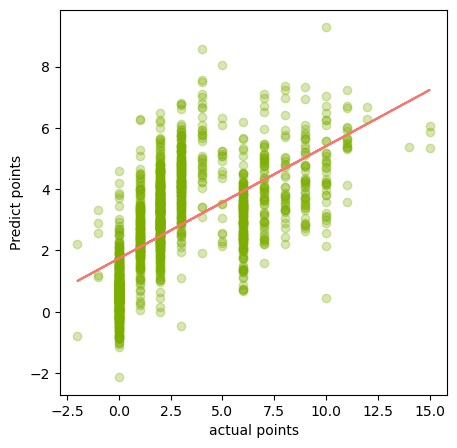

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_gks, y=y_lr_train_pred_gks, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_gks, y_lr_train_pred_gks, 1)
p = np.poly1d(z)

plt.plot(y_gks, p(y_gks), '#F8766D')
plt.ylabel('Predict points')
plt.xlabel('actual points')

In [229]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.08, random_state=42)
model.fit(x_gks, y_gks)

# Predictions
y_pred_gks = model.predict(x_gks_test)

# Evaluation
mae = mean_absolute_error(y_gks_test, y_pred_gks)
r2 = r2_score(y_gks_test, y_pred_gks)
print(f"MAE: {mae}, R²: {r2}")

MAE: 1.6636343158663613, R²: 0.414579749673365


In [230]:
y_lr_train_pred_gks=model.predict(x_gks)
lr_train_mse_gks = mean_squared_error(y_gks, y_lr_train_pred_gks)

lr_test_mse_gks = mean_squared_error(y_gks_test, y_pred_gks)

In [233]:
lr_train_mse_gks

3.7371899495967784

In [235]:
lr_test_mse_gks

5.217107853323603

In [1022]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [237]:
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(x_gks, y_gks)
rf_preds = rf.predict(x_gks_test)
print("Random Forest Regressor - R2:", r2_score(y_gks_test, rf_preds))


Random Forest Regressor - R2: 0.37783243828070523


In [1000]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(x_gks, y_gks)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


In [1038]:
# Gradient Boosting Regressor (sklearn)
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(x_gks, y_gks)
gbr_preds = gbr.predict(x_gks_test)
print("Gradient Boosting Regressor - R2:", r2_score(y_gks_test, gbr_preds))

# XGBoost
xgb = XGBRegressor(random_state=42, eval_metric='rmse')
xgb.fit(x_gks, y_gks)
xgb_preds = xgb.predict(x_gks_test)
print("XGBoost - R2:", r2_score(y_gks_test, xgb_preds))

# LightGBM
lgb = LGBMRegressor(random_state=42)
lgb.fit(x_gks, y_gks)
lgb_preds = lgb.predict(x_gks_test)
print("LightGBM - R2:", r2_score(y_gks_test, lgb_preds))

# HistGradientBoostingRegressor (sklearn)
hist_gbr = HistGradientBoostingRegressor(random_state=42)
hist_gbr.fit(x_gks, y_gks)
hist_gbr_preds = hist_gbr.predict(x_gks_test)
print("HistGradientBoostingRegressor - R2:", r2_score(y_gks_test, hist_gbr_preds))


Gradient Boosting Regressor - R2: 0.40718984723452656
XGBoost - R2: 0.3043947219848633
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 1639, number of used features: 25
[LightGBM] [Info] Start training from score 2.744966
LightGBM - R2: 0.35645659323573864
HistGradientBoostingRegressor - R2: 0.36635350168319347


## Fwds

In [532]:
from sklearn.linear_model import LinearRegression

In [534]:
reg_fwds = LinearRegression().fit(x_fwds, y_fwds)

In [536]:
y_lr_train_pred_fwds = reg_fwds.predict(x_fwds)
y_lr_test_pred_fwds = reg_fwds.predict(x_fwds_test)

In [538]:

from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse_fwds = mean_squared_error(y_fwds, y_lr_train_pred_fwds)
lr_train_r2_fwds = r2_score(y_fwds, y_lr_train_pred_fwds)

lr_test_mse_fwds = mean_squared_error(y_fwds_test, y_lr_test_pred_fwds)
lr_test_r2_fwds = r2_score(y_fwds_test, y_lr_test_pred_fwds)

In [540]:

print('LR MSE (Train): ', lr_train_mse_fwds)
print('LR R2 (Train): ', lr_train_r2_fwds)
print('LR MSE (Test): ', lr_test_mse_fwds)
print('LR R2 (Test): ', lr_test_r2_fwds)

LR MSE (Train):  1.2065022689782827
LR R2 (Train):  0.8833821555803865
LR MSE (Test):  1.7465589324112258
LR R2 (Test):  0.8416054467792677


Text(0.5, 0, 'Actual')

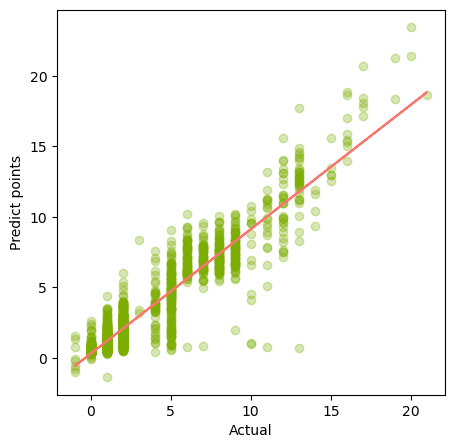

In [542]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_fwds, y=y_lr_train_pred_fwds, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_fwds, y_lr_train_pred_fwds, 1)
p = np.poly1d(z)

plt.plot(y_fwds, p(y_fwds), '#F8766D')
plt.ylabel('Predict points')
plt.xlabel('Actual')

In [23]:
from sklearn.linear_model import SGDRegressor

In [29]:
model = SGDRegressor(max_iter=2000, tol=None)

In [31]:
model.partial_fit(X_train_gks, y_train_gks)

SGDRegressor(max_iter=2000, tol=None)

In [33]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2022-23/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

gks=df.loc[df['position']=="GK"]
defs=df.loc[df['position']=="DEF"]
mids=df.loc[df['position']=="MID"]
fwds=df.loc[df['position']=="FWD"]

y_gks=gks['total_points']
y_defs=defs['total_points']
y_mids=mids['total_points']
y_fwds=fwds['total_points']

x_gks=gks.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_defs=defs.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_mids=mids.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_fwds=fwds.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)

X_train_gks, X_test_gks, y_train_gks, y_test_gks = train_test_split(
  x_gks, y_gks, random_state=104,test_size=0.2, shuffle=False)

In [37]:
y_pred = model.predict(X_test_gks)

In [43]:

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_gks, y_pred)
r2 = r2_score(y_test_gks, y_pred)



In [45]:
mse

1.7030125561088398e+41

In [47]:
r2

-4.391584760684341e+40

## Players DF

In [230]:
def fetch_data_new1(url, players_url, fix_url, teams_url):

    # Read CSVs
    df = pd.read_csv(url, encoding="latin1")
    df2 = pd.read_csv(players_url)
    df_fix_raw=pd.read_csv(fix_url)
    df_teams_raw=pd.read_csv(teams_url)

    # Dropping unnecessary columns and creating first_name and last_name for join
    df[['first_name', 'second_name']] = df['name'].str.split(' ', n=1, expand=True)
    df2=df2[['first_name', 'second_name', 'team', 'web_name']]
    df_fix=df_fix_raw[['id', 'team_a', 'team_h', 'team_h_difficulty', 'team_a_difficulty']]
    df_teams=df_teams_raw[['name', 'id', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away']]
    

    teams_away=df_teams[['name', 'id', 'strength', 'strength_overall_away', 'strength_attack_away', 'strength_defence_away']]
    teams_home=df_teams[['name', 'id', 'strength', 'strength_overall_home', 'strength_attack_home', 'strength_defence_home']]

    # Merge for team_a (away team)
    df_fix = df_fix.merge(
    teams_away,
    how='left',
    left_on='team_a',
    right_on='id',
    suffixes=('', '_team_a')
    )

    # Merge for team_h (home team)
    df_fix = df_fix.merge(
    teams_home,
    how='left',
    left_on='team_h',
    right_on='id',
    suffixes=('', '_team_h')
    )

    
    if 'expected_assists' in df.columns:
        df.drop(['expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'starts'], axis=1, inplace=True)


    # Creating 'form' column which is mean of total points from the last 5 GWs
    df = df.sort_values(by=['name', 'GW'])
    df['form'] = (
    df.groupby('name')['total_points']
    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Ensure the index matches the original DataFrame
    )
    df['form'] = df.groupby('name')['form'].transform(lambda x: x.fillna(0))

    columns_to_process = ['minutes', 'goals_scored', 'goals_conceded', 'bonus', 'assists', 'xP']

    df = df.sort_values(by=['name', 'GW'])

    for col in columns_to_process:
        new_col = f'{col}_rolling_avg'  # Create a new column name
        df[new_col] = (
        df.groupby('name')[col]
        .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
        .reset_index(level=0, drop=True)  # Ensure the index matches the original DataFrame
        )
        # Fill NaN values with 0 in the new column
        df[new_col] = df.groupby('name')[new_col].transform(lambda x: x.fillna(0))

    # Taking cummulative stats from the previous GWs
    columns_to_cumsum = ['goals_scored', 'assists', 'bonus', 'yellow_cards', 'clean_sheets', 'goals_conceded']

    # Apply cumulative sum for each column grouping by 'name', excluding the current row
    for col in columns_to_cumsum:
        df[col] = df.groupby('name')[col].cumsum().shift(1, fill_value=0)

    df.update(
    df.groupby('name')[columns_to_cumsum].transform(lambda x: x.mask(x.index == x.index.min(), 0))
    )

    df['cumulative_minutes'] = (
    df.groupby('name')['minutes']
    .cumsum()                # Compute cumulative sum
    .shift(1, fill_value=0)  # Shift down by 1 row, keeping first as 0
    )
    df['cumulative_minutes'] = df.groupby('name')['cumulative_minutes'].transform(
    lambda x: x.mask(x.index == x.index.min(), 0)
    )

    df = df.groupby('name').filter(lambda x: x['cumulative_minutes'].iloc[-1] >= 600)

    #Merging fixtures dataframe to get 'fixture difficulty'
    df=pd.merge(df, df_fix, left_on='fixture', right_on='id', how='left')
    
    df['fixture_difficulty']=np.where(df['was_home'], df['team_h_difficulty'], df['team_a_difficulty'])

    # Merging teams dataframe to obtain team strength stats
    #df=pd.merge(df, df_teams, left_on='team', right_on='name', how='left')
    df['strength_overall']=np.where(df['was_home'], df['strength_overall_home'], df['strength_overall_away'])
    df['strength_attack']=np.where(df['was_home'], df['strength_attack_home'], df['strength_attack_away'])
    df['strength_defence']=np.where(df['was_home'], df['strength_defence_home'], df['strength_defence_away'])
    df['opposition_strength']=np.where(df['was_home'], df['strength_overall_away'], df['strength_overall_home'])
    df['opposition_attack']=np.where(df['was_home'], df['strength_attack_away'], df['strength_attack_home'])
    df['opposition_defence']=np.where(df['was_home'], df['strength_defence_away'], df['strength_defence_home'])

    # Define a mapping for the positions
    position_mapping = {'GK': 1, 'GKP': 1, 'DEF': 2, 'MID': 3, 'FWD': 4}

    # Map the position values to numerical values
    df['position_num'] = df['position'].map(position_mapping)

    # Verify the transformation
    #rows_with_nulls = df[df.isnull().any(axis=1)]

    # Display the rows
    #print("Rows with at least one null value:")
    #print(rows_with_nulls[['position', 'position_num', 'name_x']].head(5))
    #print(url)

    
    df=df.drop(['team_h_difficulty', 'team_a_difficulty', 'team_a_score', 'team_h_score', 'opponent_team', 'xP', 'kickoff_time', 'element'], axis=1)
    
    # Merging df2 to get team name
    merged_df=pd.merge(df, df2, on=['first_name', 'second_name'], how='inner')
    merged_df=merged_df.drop(['team_x', 'team_y', 'position', 'first_name', 'second_name', 'bps', 'round', 'name_y', 'id', 'minutes', 'own_goals', 'GW', 'name_team_h', 'team_a', 'team_h', 'id_team_a', 'id_team_h', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'transfers_balance', 'saves', 'penalties_missed', 'penalties_saved', 'red_cards', 'yellow_cards', 'was_home'],axis=1)
    print(merged_df.columns)


    return merged_df

In [232]:
X_train=[]
X_test=[]

In [234]:
for i in range(20,23):
    gw_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/gws/merged_gw.csv"
    players_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/players_raw.csv"
    fixtures_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/fixtures.csv"
    teams_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/teams.csv"
    df=fetch_data_new1(gw_url, players_url, fixtures_url, teams_url)
    if i < 22:
        X_train.append(df)
    else:
        X_test.append(df)

Index(['name_x', 'assists', 'bonus', 'clean_sheets', 'creativity', 'fixture',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'selected',
       'threat', 'total_points', 'transfers_in', 'transfers_out', 'value',
       'form', 'minutes_rolling_avg', 'goals_scored_rolling_avg',
       'goals_conceded_rolling_avg', 'bonus_rolling_avg',
       'assists_rolling_avg', 'xP_rolling_avg', 'cumulative_minutes',
       'strength', 'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_attack', 'strength_defence', 'opposition_strength',
       'opposition_attack', 'opposition_defence', 'position_num', 'web_name'],
      dtype='object')
Index(['name_x', 'assists', 'bonus', 'clean_sheets', 'creativity', 'fixture',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'selected',
       'threat', 'total_points', 'transfers_in', 'transfers_out', 'value',
       'form', 'minutes_rolling_avg', 'goals_scored_rolling_avg',
       'goals_conceded_rol

In [235]:
X_train=pd.concat(X_train, ignore_index=True)

X_test=X_test[0]

In [236]:
rows_with_nulls = X_train[X_train.isnull().any(axis=1)]

# Display the rows
print("Rows with at least one null value:")
rows_with_nulls.head(45)

Rows with at least one null value:


,name_x,assists,bonus,clean_sheets,creativity,fixture,goals_conceded,goals_scored,ict_index,influence,...,strength_team_h,fixture_difficulty,strength_overall,strength_attack,strength_defence,opposition_strength,opposition_attack,opposition_defence,position_num,web_name


In [237]:
y_train=X_train['total_points']
y_test=X_test['total_points']

X_train=X_train.drop(['name_x', 'total_points', 'web_name', 'fixture'], axis=1)
X_test=X_test.drop(['name_x', 'total_points', 'web_name', 'fixture'], axis=1)

### Linear Regression 

In [239]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
reg = lr.fit(X_train, y_train)

In [240]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

In [241]:
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

print('LR MSE (Train): ', lr_train_mse)
print('LR R2 (Train): ', lr_train_r2)
print('LR MSE (Test): ', lr_test_mse)
print('LR R2 (Test): ', lr_test_r2)

LR MSE (Train):  2.9005167852090077
LR R2 (Train):  0.6643706655770973
LR MSE (Test):  3.168176967285593
LR R2 (Test):  0.6162747371097705


In [242]:
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

In [243]:
lr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,2.900517,0.664371,3.168177,0.616275


Text(0.5, 0, 'Experimental LogS')

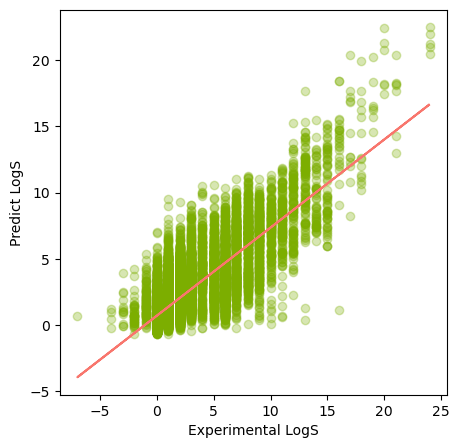

In [194]:

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_lr_train_pred, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_train, y_lr_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766D')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')

### Random forest

In [196]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=2, random_state=100)
rf.fit(X_train, y_train)

y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
print(rf_results)

df_models = pd.concat([lr_results, rf_results], axis=0)

          Method Training MSE Training R2  Test MSE   Test R2
0  Random forest     3.286594    0.619696  3.640487  0.559069


In [197]:
df_models

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,2.896272,0.664862,3.153805,0.618015
0,Random forest,3.286594,0.619696,3.640487,0.559069


In [198]:
X_train.columns

Index(['assists', 'bonus', 'clean_sheets', 'creativity', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'selected', 'threat',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'form', 'minutes_rolling_avg', 'goals_scored_rolling_avg',
       'goals_conceded_rolling_avg', 'bonus_rolling_avg',
       'assists_rolling_avg', 'xP_rolling_avg', 'cumulative_minutes',
       'strength', 'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_attack', 'strength_defence', 'opposition_strength',
       'opposition_attack', 'opposition_defence', 'position_num'],
      dtype='object')

In [199]:
X_test.columns

Index(['assists', 'bonus', 'clean_sheets', 'creativity', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'selected', 'threat',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'form', 'minutes_rolling_avg', 'goals_scored_rolling_avg',
       'goals_conceded_rolling_avg', 'bonus_rolling_avg',
       'assists_rolling_avg', 'xP_rolling_avg', 'cumulative_minutes',
       'strength', 'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_attack', 'strength_defence', 'opposition_strength',
       'opposition_attack', 'opposition_defence', 'position_num'],
      dtype='object')

### Gradient

In [201]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model1 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model1.fit(X_train, y_train)
print(X_train.columns)

# Predictions
y_gr_train_pred = model1.predict(X_train)
y_gr_test_pred = model1.predict(X_test)

gr_train_mse = mean_squared_error(y_train, y_gr_train_pred)
gr_train_r2 = r2_score(y_train, y_gr_train_pred)

gr_test_mse = mean_squared_error(y_test, y_gr_test_pred)
gr_test_r2 = r2_score(y_test, y_gr_test_pred)

print('LR MSE (Train): ', gr_train_mse)
print('LR R2 (Train): ', gr_train_r2)
print('LR MSE (Test): ', gr_test_mse)
print('LR R2 (Test): ', gr_test_r2)

Index(['assists', 'bonus', 'clean_sheets', 'creativity', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'selected', 'threat',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'form', 'minutes_rolling_avg', 'goals_scored_rolling_avg',
       'goals_conceded_rolling_avg', 'bonus_rolling_avg',
       'assists_rolling_avg', 'xP_rolling_avg', 'cumulative_minutes',
       'strength', 'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_attack', 'strength_defence', 'opposition_strength',
       'opposition_attack', 'opposition_defence', 'position_num'],
      dtype='object')
LR MSE (Train):  2.307077718250778
LR R2 (Train):  0.7330396559030357
LR MSE (Test):  2.8478451448190216
LR R2 (Test):  0.6550728895038287


<Axes: >

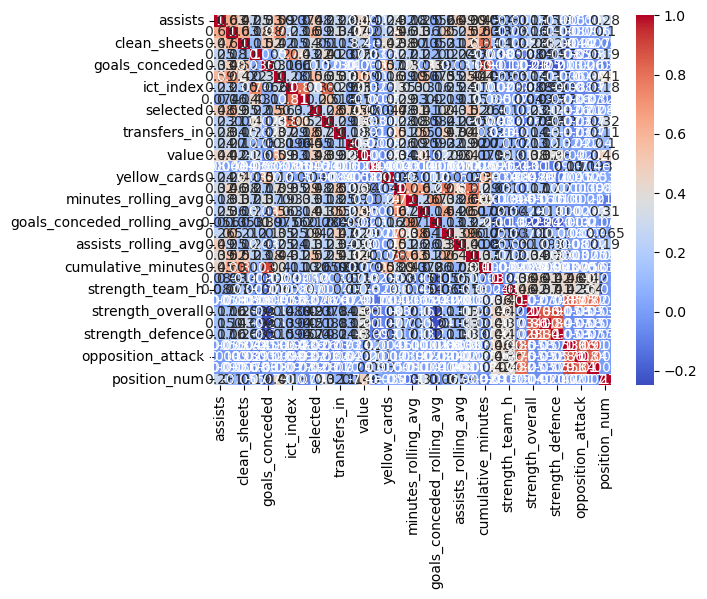

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [228]:
importance = model1.feature_importances_
for i, col in enumerate(X_train.columns):
    print(f"{col}: {importance[i]}")

assists: 0.00026336816015121465
bonus: 0.00041255736673113404
clean_sheets: 0.0006230638209318048
creativity: 0.0029884608186022833
goals_conceded: 0.0007985632246039615
goals_scored: 0.00039465069003371644
ict_index: 0.1305031253981326
influence: 0.7974042835470313
selected: 0.0004794739628130481
threat: 0.014079808838033293
transfers_in: 0.0053573947546188185
transfers_out: 0.00035976729886474305
value: 0.007400492839845466
was_home: 0.00015367959011292282
yellow_cards: 0.00020724072937465735
form: 0.0005393540069184749
minutes_rolling_avg: 0.00022327886339150972
goals_scored_rolling_avg: 0.00012112443235255672
goals_conceded_rolling_avg: 0.0011828598830889313
bonus_rolling_avg: 0.0002247988253493598
assists_rolling_avg: 8.916373280696501e-06
xP_rolling_avg: 0.0033295131864338884
cumulative_minutes: 0.002048253890553431
strength: 4.763876067410228e-05
strength_team_h: 0.0001396382972874939
fixture_difficulty: 0.005025336107897714
strength_overall: 0.001776812084819411
strength_attack